In [2]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import importlib

import sys
sys.path.append('../')
import snowFun

In [76]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')
folder_slope = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Slopes')
folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')
folder_debris = os.path.join(folder_AGVA, 'debris cover', 'raster')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi)

### open the validated big glacier dates
path_open = os.path.join(folder_save, 'Big Glacier Check', "first_look.csv")
df_dates = pd.read_csv(path_open)

In [77]:
df_dates

,RGIId,Area,2018,2019,2020,2021,2022
0,RGI60-01.17423,[512.357],1,2019-07-18,2020-08-11,1,1
1,RGI60-01.13538,[514.803],2018-09-05,2019-08-09,2020-08-28,1,1
2,RGI60-01.01390,[521.396],2018-09-29,1,2020-09-15,1,1
3,RGI60-01.03377,[523.786],1,1,1,2021-08-23,1
4,RGI60-01.27108,[534.228],2018-09-26,1,2020-09-05,1,1
5,RGI60-01.20796,[549.286],2018-09-12,2019-09-04,2020-09-16,2021-08-22,2022-09-28
6,RGI60-01.16545,[582.83],2018-09-20,1,1,1,2022-08-12
7,RGI60-01.16121,[592.219],1,1,2020-09-11,2021-09-04,1
8,RGI60-01.04375,[612.706],1,2019-08-09,1,1,2022-09-12
9,RGI60-01.26738,[718.416],1,1,1,1,1


In [78]:
# iterate though each of the large glaciers
for idx,row in df_dates.iterrows():
#     if idx>0: continue
    row_save=row
     
    # grab rgiid
    rgiid = row['RGIId']
    print(idx, len(df_dates), rgiid)

    # open the originally IDed annual best data, add year column
    path_open = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
    ela_df_orig = pd.read_csv(path_open)
    ela_df_orig['year'] = [ int(d[:4]) for d in ela_df_orig['date'] ]
    
    # open glacier mask
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc"), chunks='auto').glacier
    
    # open debris products
    path_debris = os.path.join(folder_debris, f"{rgiid}_debris.tif")
    debris = riox.open_rasterio(path_debris)
    
    # open glacier slope
    glacier_slope = xr.open_dataset(os.path.join(folder_slope, f"S2_{rgiid}_slope.nc"), chunks='auto').slope
    max_slope = 25
    
    # create binary mask for what is usable slopes
    slope_mask = xr.where(glacier_slope<=max_slope, 1, 0)
    
    # make sure dimensions match up
    slope_mask = slope_mask.reindex_like(glacier_mask, method='nearest')
    
    # function to format metadata and attributes
    def format_xr_to_save(xr_da):
        xr_da.attrs["res"] = (10,10)
        xr_da.attrs["crs"] = "EPSG:3338"
        xr_da.attrs["transform"] = [10,0,0,0,-10,0]
        xr_da.attrs["_FillValue"] = 0
        xr_da.attrs["long_name"] = rgiid
        xr_da.attrs["description"] = "0: off glacier, no data. 1: ablation. 2: accumulation. 3: on glacier, no data"
        xr_da.name = "accumulation_area"

        xr_da.x.attrs["units"] = "meters"
        xr_da.y.attrs["units"] = "meters"
        xr_da.x.attrs["long_name"] = 'x'
        xr_da.y.attrs["long_name"] = 'y'

        return xr_da
    
    ### then go through each year
    all_maps = [] # list to save all obs
    for y in [2018,2019,2020,2021,2022]:
#         if y!=2018: continue

        print(y)
            
        # get the date of the best snow cover observation
        best_date = row[str(y)]
        if best_date=='1':
            best_date = ela_df_orig[ela_df_orig['year']==y]['date'].values[0]
        
        # we are going to open the original 10 m resolution snow cover data and reprocess/filter/smooth just this date
        path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{y}_daily_AAs_shadowed.nc")
        snow = xr.open_dataset(path_open, chunks={'time':1})
        
        # we want to make 1=snow, 0=ablation, nan=cloud,shadow,off-glacier
        snow = snow.where(snow!=0, np.nan).where(snow<=1, 0)
        
        # get list of the date of every observation
        time_values = pd.to_datetime(snow.time.values)
        
        # calculate how many days separate each of time_values and best_date
        diffs = time_values-pd.to_datetime(best_date)
        
        # select just the days within the correct range
        days_plus = 3
        days_minus = 7
        good_dates = time_values[(diffs>=f"-{days_minus}d") & (diffs<=f"{days_plus}d")].values
        
        # select obs from these dates, take average
        if len(good_dates)==1: # we have to treat it differently if there is only 1 "good date"
            snow_out = snow.sel(time = slice(good_dates[0], good_dates[-1]))['class']

        else:
            snow_out = snow.sel(time = slice(good_dates[0], good_dates[-1])).mean(dim='time', skipna=True).expand_dims(time=[pd.to_datetime(best_date)])['class']
            
        # fix to 0(nodata), 1(ablation), 2(snow)
        snow_out = xr.where(snow_out.isnull(), 0, xr.where(snow_out>=0.5, 2, 1)).astype('uint8')#.expand_dims(time=[date])
        
        # add debris cover where we have no data
        snow_out = xr.where( (debris==1) & (snow_out==0), 1, snow_out)

        # add to list to save
        all_maps.append(snow_out.copy())
        
        # last formatting
        snow_out = format_xr_to_save(snow_out).squeeze()
        
        # define path to save, save
        out_path = os.path.join(folder_save, 'Big Glacier Check', 'reprocessed', f"S2_{rgiid}_{y}_AA_reprocessed.tif")
        snow_out.rio.to_raster(raster_path=out_path, compress='DEFLATE')
    
    # save 5-year average product
    if len(all_maps)>0:
        print('all')
        print()
        
        # define save paths
        path_xr_all = os.path.join(folder_save, 'Big Glacier Check', 'reprocessed', f"S2_{rgiid}_2018_2022_annual_AAs_reprocessed.nc")
        path_tif_avg = os.path.join(folder_save, 'Big Glacier Check', 'reprocessed', f"S2_{rgiid}_2018_2022_average_AA_reprocessed.tif")
        
        # compute average map
        all_maps = xr.concat(all_maps, dim='time')
        all_maps = all_maps.where(all_maps.isin([1,2]), np.nan)
        average_map = all_maps.median('time', skipna=True).astype('uint8')#+glacier_mask
        
        save_xr_all = format_xr_to_save(all_maps.astype('uint8'))
        save_xr_avg = format_xr_to_save(average_map)

        # specify compression/encoding
        encoding = {"accumulation_area":{"zlib": True}}
        
        # save
        save_xr_all.to_netcdf(path_xr_all, encoding=encoding)
        save_xr_avg.rio.to_raster(raster_path=path_tif_avg, compress='DEFLATE')
print("Done!")

0 22 RGI60-01.17423
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


1 22 RGI60-01.13538
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


2 22 RGI60-01.01390
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


3 22 RGI60-01.03377
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


4 22 RGI60-01.27108
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


5 22 RGI60-01.20796
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


6 22 RGI60-01.16545
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


7 22 RGI60-01.16121
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


8 22 RGI60-01.04375
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


9 22 RGI60-01.26738
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


10 22 RGI60-01.14883
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


11 22 RGI60-01.10689
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


12 22 RGI60-01.23649
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


13 22 RGI60-01.17614
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


14 22 RGI60-01.17183
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


15 22 RGI60-01.14683
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


16 22 RGI60-01.15769
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


17 22 RGI60-01.16201
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


18 22 RGI60-01.17566
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


19 22 RGI60-01.14443
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


20 22 RGI60-01.13635
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


21 22 RGI60-01.13696
2018
2019
2020
2021
2022
all



C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Done!


In [72]:
row_save

RGIId    RGI60-01.20796
Area          [549.286]
2018         2018-09-12
2019         2019-09-04
2020         2020-09-16
2021         2021-08-22
2022         2021-09-28
Name: 5, dtype: object

In [73]:
ela_df_orig

,date,ela,observed_after_smoothing,aar,off_glacier,year
0,2018-09-14,990.0,0.9751,0.0957,False,2018
1,2019-09-09,2310.0,0.9709,0.0175,False,2019
2,2020-09-28,860.0,0.7868,0.3037,False,2020
3,2021-09-06,610.0,0.8401,0.3877,False,2021
4,2022-10-01,610.0,0.9501,0.4654,False,2022


In [74]:
good_dates

array([], dtype='datetime64[ns]')

In [66]:
snow_out

<xarray.DataArray 'accumulation_area' (y: 3704, x: 3767, band: 1, time: 1)>
dask.array<where, shape=(3704, 3767, 1, 1), dtype=uint8, chunksize=(3704, 3767, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6.473e+05 6.473e+05 ... 6.849e+05 6.85e+05
  * y            (y) float64 1.331e+06 1.331e+06 ... 1.294e+06 1.294e+06
    spatial_ref  int32 0
  * band         (band) int32 1
  * time         (time) datetime64[ns] 2018-07-25
Attributes:
    res:          (10, 10)
    crs:          EPSG:3338
    transform:    [10, 0, 0, 0, -10, 0]
    _FillValue:   0
    long_name:    RGI60-01.17423
    description:  0: off glacier, no data. 1: ablation. 2: accumulation. 3: o...

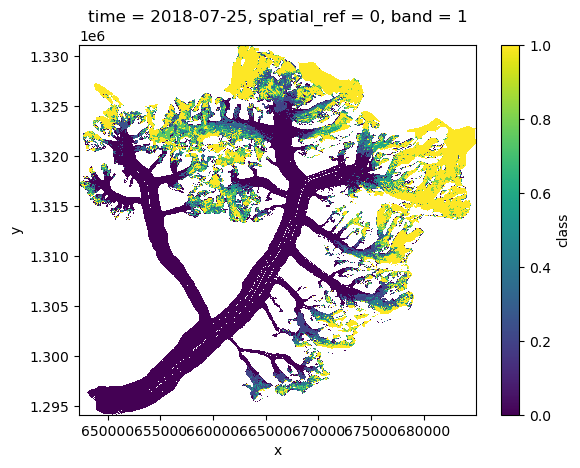

In [56]:
smoothed.squeeze().plot()

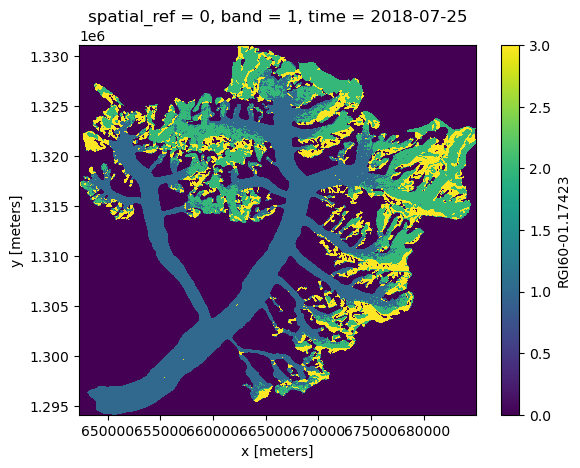

In [64]:
snow_out.squeeze().plot()